## Intro
The goal of this notebook is to see how parking citations in Los Angeles disproportionately affect low-income groups and racial minority groups.

## Install packages
Using conda to install a few packages, and pip to install matplotlib since I could not install it through conda for some weird error.

## Import packages

In [1]:
import pandas as pd
import numpy as np
import time
import requests
import geopandas as gpd
import sys
import os
import seaborn as sn
import matplotlib.pyplot as plt
os.environ['HOME'] = '/home'

## LA citation data
The data was created from using Greg's scripts. The data here was created using a 0.001 fraction of the data.

In [2]:
# read data
df = pd.read_csv('~/data/processed/2021-01-30_processed_0001samp.csv')
df.index = df.index.astype(int)
df.set_index('index', inplace=True)

# add geopandas geometry
df = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
df.head()

,state_plate,make,body_style,color,location,violation_code,violation_description,fine_amount,datetime,latitude,longitude,weekday,geometry
index,,,,,,,,,,,,,
0,CA,Kia,PA,WT,600 LARCHMONT BL N,88.13B+,METER EXP.,63,2015-12-30 11:19:00,34.081677,-118.323659,Wednesday,POINT (-118.32366 34.08168)
1,CA,Toyota,PA,GO,132 CLARK DR S,80.58L,PREFERENTIAL PARKING,68,2015-12-30 18:50:00,34.075151,-118.384839,Wednesday,POINT (-118.38484 34.07515)
2,CT,Chevrolet,PA,BN,830 SOUTH NORTON AVENUE,80.69BS,NO PARK/STREET CLEAN,73,2015-12-30 11:04:00,34.057482,-118.318860,Wednesday,POINT (-118.31886 34.05748)
3,CA,Hyundai,PA,WT,1701 LAS PALMAS AV N,88.13B+,METER EXP.,63,2015-12-30 11:15:00,34.101561,-118.336137,Wednesday,POINT (-118.33614 34.10156)
4,CA,Honda,PA,BK,1631 219TH ST,5204A-,DISPLAY OF TABS,25,2015-12-30 08:14:00,33.829107,-118.307212,Wednesday,POINT (-118.30721 33.82911)


## ZCTA .shp file
This .shp file is from https://www2.census.gov/geo/tiger/TIGER2019/ZCTA5/ and contains the geometries for all ZCTAs in the U.S. To reduce the size of the variable storing this data,the ZCTA was filtered from 90001 to 93591. I believe this includes all ZCTA for Los Angeles, plus a few more in SoCal.

In [3]:
# read data
gpd_df = gpd.read_file(os.path.expanduser('~/data/external/tl_2019_us_zcta510/tl_2019_us_zcta510.shp'))

# filter for zcta in LA (and some extra zcta's in SoCal)
gpd_df = gpd_df[(gpd_df['ZCTA5CE10'] >= '90001') & (gpd_df['ZCTA5CE10'] <= '93591')]
gpd_df.reset_index(drop=True, inplace=True)
gpd_df.head()

,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,92705,92705,B5,G6350,S,29931652,0,+33.7732570,-117.8302730,"MULTIPOLYGON (((-117.83027 33.77326, -117.8300..."
1,92706,92706,B5,G6350,S,9161338,0,+33.7658968,-117.8822237,"POLYGON ((-117.90730 33.75995, -117.90725 33.7..."
2,92707,92707,B5,G6350,S,12956927,17402,+33.7099350,-117.8704307,"MULTIPOLYGON (((-117.87836 33.66412, -117.8783..."
3,92708,92708,B5,G6350,S,23697051,33638,+33.7105823,-117.9511290,"POLYGON ((-117.98054 33.71422, -117.98053 33.7..."
4,92780,92780,B5,G6350,S,18112940,0,+33.7340083,-117.8191646,"POLYGON ((-117.84389 33.73959, -117.84384 33.7..."


## Join LA data with ZCTA geometries
To get the ZCTA for each citation, a spatial join between the citation lat/long coordinates and the ZCTA geometries.

In [4]:
# reproject geometries
df.crs = gpd_df.crs

# join citation data with ZCTA geometries
gpd_join = gpd.sjoin(df, gpd_df, how='left', op="within")
gpd_join.head()

,state_plate,make,body_style,color,location,violation_code,violation_description,fine_amount,datetime,latitude,...,index_right,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10
index,,,,,,,,,,,,,,,,,,,,,
0,CA,Kia,PA,WT,600 LARCHMONT BL N,88.13B+,METER EXP.,63,2015-12-30 11:19:00,34.081677,...,584,90004,90004,B5,G6350,S,7894528,0,+34.0761981,-118.3107225
1,CA,Toyota,PA,GO,132 CLARK DR S,80.58L,PREFERENTIAL PARKING,68,2015-12-30 18:50:00,34.075151,...,626,90048,90048,B5,G6350,S,4884083,0,+34.0729253,-118.3727108
2,CT,Chevrolet,PA,BN,830 SOUTH NORTON AVENUE,80.69BS,NO PARK/STREET CLEAN,73,2015-12-30 11:04:00,34.057482,...,585,90005,90005,B5,G6350,S,2807558,0,+34.0591634,-118.3068924
3,CA,Hyundai,PA,WT,1701 LAS PALMAS AV N,88.13B+,METER EXP.,63,2015-12-30 11:15:00,34.101561,...,607,90028,90028,B5,G6350,S,3947879,0,+34.0999122,-118.3269118
4,CA,Honda,PA,BK,1631 219TH ST,5204A-,DISPLAY OF TABS,25,2015-12-30 08:14:00,33.829107,...,709,90501,90501,B5,G6350,S,14659585,8095,+33.8337437,-118.3140219


## Census data
The income and race data of each ZCTA in California was obtained through the census API.

In [5]:
# download income data by zipcode
# Documentation: https://www.census.gov/data/developers/data-sets/acs-5year.html
# Examples:      https://api.census.gov/data/2019/acs/acs5/subject/examples.html
# Variables:     https://api.census.gov/data/2019/acs/acs5/subject/variables.html
census_income_response = requests.get('https://api.census.gov/data/2019/acs/acs5/subject?' + \
                        'get={}'.format(','.join(["S1901_C01_0" + str(x).zfill(2) + "E" for x in range(2,14)])) + \
                        '&for=zip%20code%20tabulation%20area:*' + \
                        '&in=state:06')
zcta_income = pd.DataFrame(census_income_response.json())
zcta_income.rename(columns=zcta_income.iloc[0], inplace = True)
zcta_income.drop([0], inplace = True)
zcta_income.drop('state', axis=1, inplace=True)
zcta_income.insert(0, "zcta", zcta_income.pop("zip code tabulation area"))
zcta_income[list(zcta_income)] = zcta_income[list(zcta_income)].astype('float')
zcta_income.zcta = zcta_income.zcta.astype('int').astype('string')
zcta_income

,zcta,S1901_C01_002E,S1901_C01_003E,S1901_C01_004E,S1901_C01_005E,S1901_C01_006E,S1901_C01_007E,S1901_C01_008E,S1901_C01_009E,S1901_C01_010E,S1901_C01_011E,S1901_C01_012E,S1901_C01_013E
1,93252,9.1,8.4,17.2,12.7,20.0,15.5,9.8,1.1,3.5,2.6,36726.0,47845.0
2,93270,11.6,8.4,24.0,6.7,7.4,17.8,4.8,9.9,3.1,6.2,34023.0,65435.0
3,93291,5.6,5.5,11.0,6.9,12.6,15.3,14.4,13.9,7.0,7.9,61599.0,85165.0
4,93304,6.9,8.3,12.5,14.6,17.7,20.9,9.4,5.2,3.3,1.2,40710.0,53284.0
5,93306,5.6,4.4,11.2,9.9,14.6,17.8,12.2,14.1,5.3,4.9,55133.0,75527.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1760,96108,0.0,20.0,0.0,16.4,7.3,0.0,56.4,0.0,0.0,0.0,77938.0,56005.0
1761,96110,3.8,0.0,3.8,7.5,28.3,13.2,17.0,5.7,20.8,0.0,59063.0,75675.0
1762,96115,0.0,20.0,34.7,0.0,0.0,40.0,5.3,0.0,0.0,0.0,-666666666.0,38469.0
1763,96116,0.0,0.0,0.0,0.0,0.0,66.1,33.9,0.0,0.0,0.0,52477.0,68066.0


In [6]:
# download race data by zipcode
# Documentation: https://www.census.gov/data/developers/data-sets/acs-5year.html
# Examples: https://api.census.gov/data/2019/acs/acs5/profile/examples.html
# Variables: https://api.census.gov/data/2019/acs/acs5/profile/variables.html
census_race_response = requests.get('https://api.census.gov/data/2019/acs/acs5/profile?' + \
                        'get={}'.format(','.join(["DP05_00" + str(x).zfill(2) + "E" + "," + "DP05_00" + str(x).zfill(2) + "PE" for x in range(63,86)])) + \
                        '&for=zip%20code%20tabulation%20area:*' + \
                        '&in=state:06')
zcta_race = pd.DataFrame(census_race_response.json())
zcta_race.rename(columns=zcta_race.iloc[0], inplace = True)
zcta_race.drop([0], inplace = True)
zcta_race.drop('state', axis=1, inplace=True)
zcta_race.insert(0, "zcta", zcta_race.pop("zip code tabulation area"))
zcta_race[list(zcta_race)] = zcta_race[list(zcta_race)].astype('float')
zcta_race.zcta = zcta_race.zcta.astype('int').astype('string')
zcta_race

,zcta,DP05_0063E,DP05_0063PE,DP05_0064E,DP05_0064PE,DP05_0065E,DP05_0065PE,DP05_0066E,DP05_0066PE,DP05_0067E,...,DP05_0081E,DP05_0081PE,DP05_0082E,DP05_0082PE,DP05_0083E,DP05_0083PE,DP05_0084E,DP05_0084PE,DP05_0085E,DP05_0085PE
1,93252,2488.0,2488.0,2186.0,87.9,24.0,1.0,117.0,4.7,152.0,...,0.0,0.0,0.0,0.0,81.0,3.3,17.0,0.7,64.0,2.6
2,93270,5367.0,5367.0,3486.0,65.0,10.0,0.2,249.0,4.6,70.0,...,4.0,0.1,0.0,0.0,16.0,0.3,0.0,0.0,16.0,0.3
3,93291,59270.0,59270.0,42247.0,71.3,838.0,1.4,1387.0,2.3,6352.0,...,157.0,0.3,168.0,0.3,1081.0,1.8,80.0,0.1,1001.0,1.7
4,93304,49115.0,49115.0,28519.0,58.1,6996.0,14.2,1197.0,2.4,1441.0,...,64.0,0.1,41.0,0.1,511.0,1.0,38.0,0.1,473.0,1.0
5,93306,72280.0,72280.0,60532.0,83.7,2654.0,3.7,1554.0,2.1,2241.0,...,159.0,0.2,176.0,0.2,914.0,1.3,84.0,0.1,830.0,1.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1760,96108,80.0,80.0,80.0,100.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1761,96110,126.0,126.0,126.0,100.0,0.0,0.0,5.0,4.0,0.0,...,0.0,0.0,0.0,0.0,5.0,4.0,0.0,0.0,5.0,4.0
1762,96115,115.0,115.0,111.0,96.5,4.0,3.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1763,96116,172.0,172.0,172.0,100.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
#merge income and race to form demographic dataframe
zcta_dem = zcta_income.merge(zcta_race, on='zcta', how='outer')
zcta_dem.head()

,zcta,S1901_C01_002E,S1901_C01_003E,S1901_C01_004E,S1901_C01_005E,S1901_C01_006E,S1901_C01_007E,S1901_C01_008E,S1901_C01_009E,S1901_C01_010E,...,DP05_0081E,DP05_0081PE,DP05_0082E,DP05_0082PE,DP05_0083E,DP05_0083PE,DP05_0084E,DP05_0084PE,DP05_0085E,DP05_0085PE
0,93252,9.1,8.4,17.2,12.7,20.0,15.5,9.8,1.1,3.5,...,0.0,0.0,0.0,0.0,81.0,3.3,17.0,0.7,64.0,2.6
1,93270,11.6,8.4,24.0,6.7,7.4,17.8,4.8,9.9,3.1,...,4.0,0.1,0.0,0.0,16.0,0.3,0.0,0.0,16.0,0.3
2,93291,5.6,5.5,11.0,6.9,12.6,15.3,14.4,13.9,7.0,...,157.0,0.3,168.0,0.3,1081.0,1.8,80.0,0.1,1001.0,1.7
3,93304,6.9,8.3,12.5,14.6,17.7,20.9,9.4,5.2,3.3,...,64.0,0.1,41.0,0.1,511.0,1.0,38.0,0.1,473.0,1.0
4,93306,5.6,4.4,11.2,9.9,14.6,17.8,12.2,14.1,5.3,...,159.0,0.2,176.0,0.2,914.0,1.3,84.0,0.1,830.0,1.1


In [8]:
# find agg data per ZCTA
gpd_join_dem = gpd_join.groupby('ZCTA5CE10').agg({'fine_amount':['mean', 'size']})
gpd_join_dem.columns = ['mean_fine_amount', 'count']
gpd_join_dem.reset_index(inplace=True)

# join with ZCTA demographics
gpd_join_dem = gpd_join_dem.merge(zcta_dem, how='left', left_on='ZCTA5CE10', right_on='zcta')

# join with geometry
gpd_join_dem = gpd_join_dem.merge(gpd_df[['ZCTA5CE10', 'geometry']], how='left', on='ZCTA5CE10', )

# rename some columns
gpd_join_dem.rename({"S1901_C01_012E": "median_income"}, axis=1, inplace=True)
gpd_join_dem.rename({"DP05_0070E": "population"}, axis=1, inplace=True)
gpd_join_dem.rename({"DP05_0071PE": "hispanic_percent"}, axis=1, inplace=True)


# create more attributes
gpd_join_dem['count_per_thousand'] = gpd_join_dem['count'] / (gpd_join_dem['population'] / 1000)
gpd_join_dem['nonwhite_percent'] = 100-gpd_join_dem['DP05_0064PE']
gpd_join_dem['diversity_index'] = 1-(gpd_join_dem['DP05_0064PE']/100)**2-(gpd_join_dem['DP05_0065PE']/100)**2-(gpd_join_dem['DP05_0066PE']/100)**2-(gpd_join_dem['DP05_0067PE']/100)**2-(gpd_join_dem['DP05_0068PE']/100)**2-(gpd_join_dem['DP05_0069PE']/100)**2
labels4=['0-25%', '25-50%', '50-75%', '75-100%']
labels5=['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
gpd_join_dem['median_income_quantile'] = pd.qcut(gpd_join_dem['median_income'], q=5, labels=labels5)
gpd_join_dem['nonwhite_percent_quantile'] = pd.qcut(gpd_join_dem['nonwhite_percent'], q=5, labels=labels5)
gpd_join_dem['hispanic_percent_quantile'] = pd.qcut(gpd_join_dem['hispanic_percent'], q=5, labels=labels5)
gpd_join_dem['diversity_index_quantile'] = pd.qcut(gpd_join_dem['diversity_index'], q=5, labels=labels5)
gpd_join_dem['coords'] = gpd_join_dem['geometry'].apply(lambda x: x.representative_point().coords[:])
gpd_join_dem['coords'] = [coords[0] for coords in gpd_join_dem['coords']]

# turn to gpd
gpd_join_dem = gpd.GeoDataFrame(gpd_join_dem)
gpd_join_dem.head(3)

,ZCTA5CE10,mean_fine_amount,count,zcta,S1901_C01_002E,S1901_C01_003E,S1901_C01_004E,S1901_C01_005E,S1901_C01_006E,S1901_C01_007E,...,DP05_0085PE,geometry,count_per_thousand,nonwhite_percent,diversity_index,median_income_quantile,nonwhite_percent_quantile,hispanic_percent_quantile,diversity_index_quantile,coords
0,90001,72.888889,9,90001,8.2,5.6,12.9,12.5,16.4,19.6,...,0.1,"POLYGON ((-118.26519 33.98923, -118.26208 33.9...",0.150421,57.2,0.582049,0-20%,60-80%,80-100%,40-60%,"(-118.24987423568686, 33.9739465)"
1,90002,72.944444,36,90002,10.4,10.5,14.4,11.6,15.5,16.4,...,0.2,"POLYGON ((-118.26516 33.94643, -118.26516 33.9...",0.675397,55.9,0.646318,0-20%,60-80%,80-100%,60-80%,"(-118.24700634665697, 33.949445499999996)"
2,90003,79.159574,94,90003,9.4,8.2,14.7,11.3,16.8,16.6,...,0.3,"POLYGON ((-118.28320 33.98914, -118.28266 33.9...",1.274922,66.2,0.642201,0-20%,80-100%,80-100%,60-80%,"(-118.27391425494615, 33.963484)"


Correlation matrix

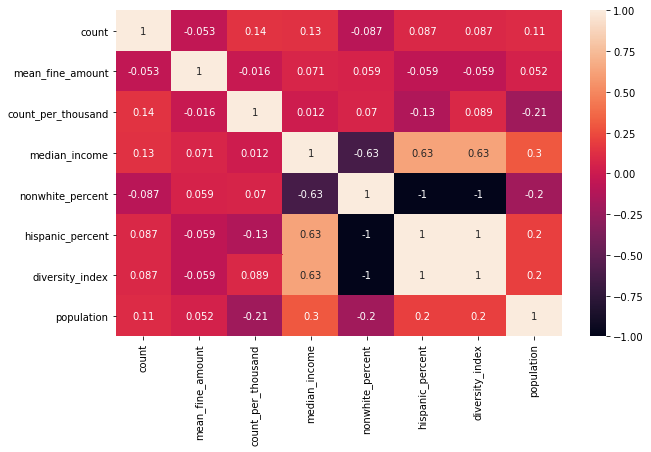

In [9]:
corr_cols = ['count', 'mean_fine_amount', 'count_per_thousand', 'median_income', 'nonwhite_percent', 'hispanic_percent', 'diversity_index', 'population']
corrMatrix = gpd_join_dem[corr_cols].corr()
fig, ax = plt.subplots(figsize=(10,6))
sn.heatmap(corrMatrix, annot=True, ax=ax)
plt.show();

### Let's plot citation count per ZCTA

<ipython-input-10-c5a3e2835c55>:17: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s=row['ZCTA5CE10'], xy=row['coords'],horizontalalignment='center')


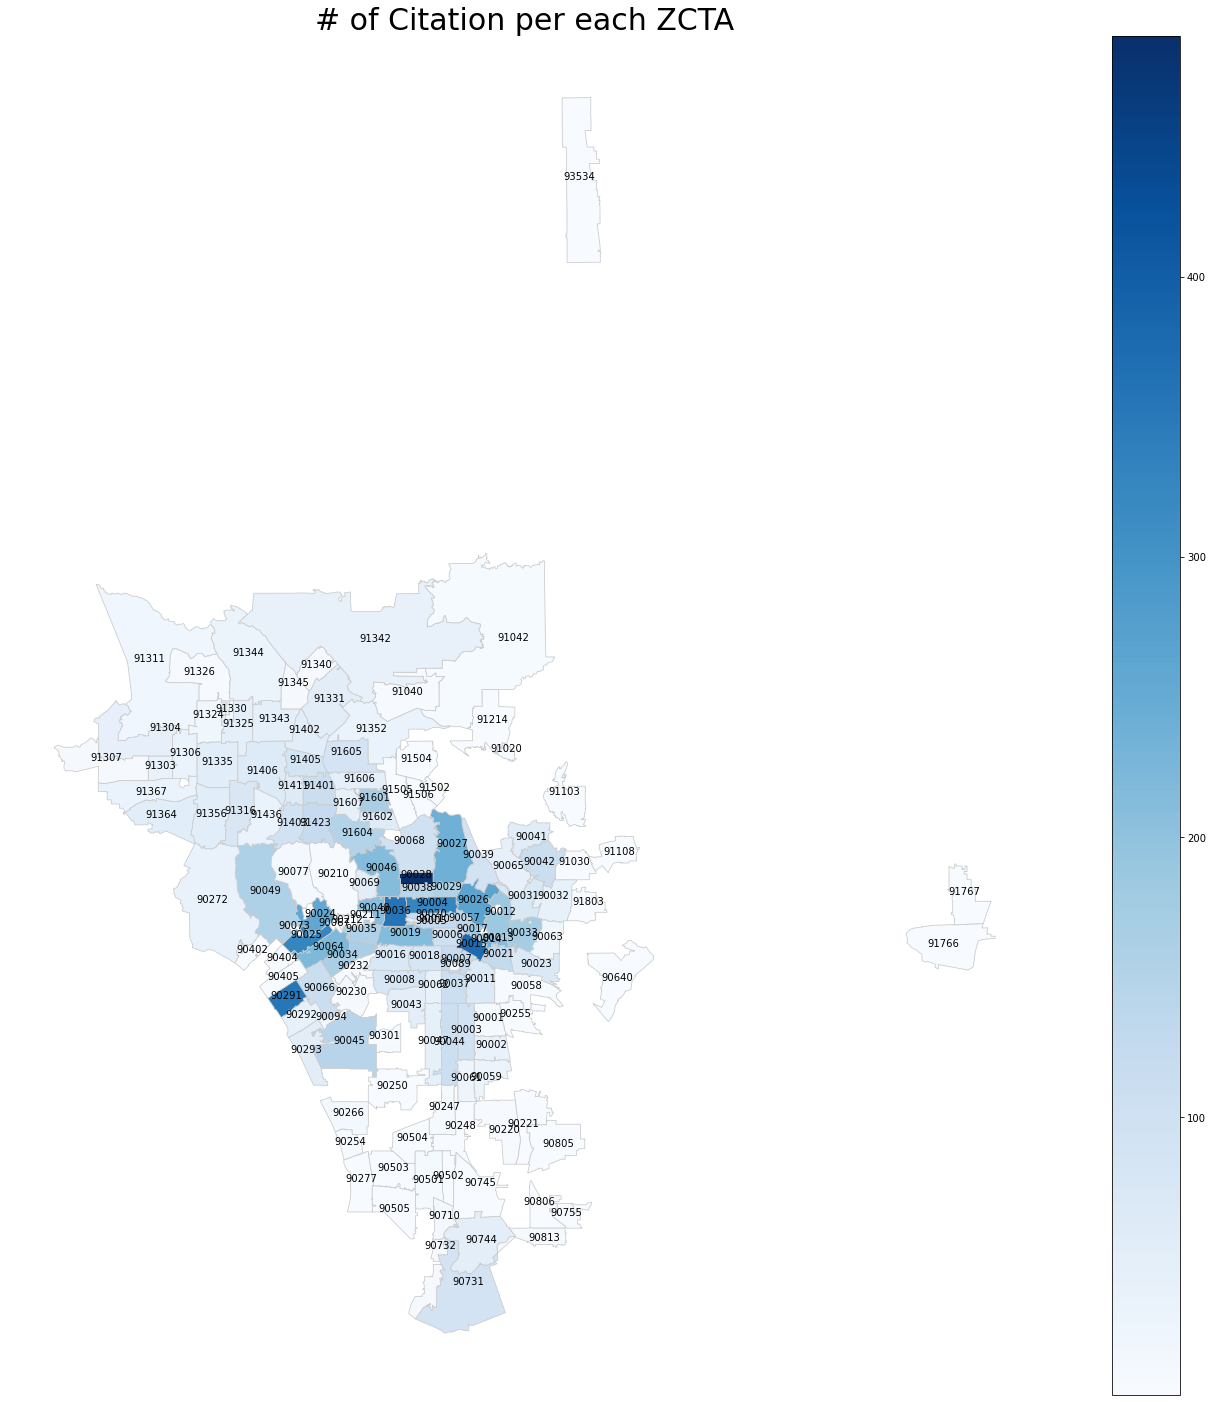

In [10]:
def plot_ZCTA(variable):
    
    # filter out low population (some data is missing/wrong for low population)
    df = gpd_join_dem[gpd_join_dem['population'] > 500].reset_index()
    
    # plot
    fig, ax = plt.subplots(1, figsize=(25, 25))
    ax.axis('off')
    ax.set_title('# of Citation per each ZCTA', fontdict={'fontsize': '30', 'fontweight' : '3'})
    fig.colorbar(plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=min(df[variable]), vmax=max(df[variable]))))

    # create map
    df.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
    
    # annotate ZCTA
    for idx, row in df.iterrows():
        plt.annotate(s=row['ZCTA5CE10'], xy=row['coords'],horizontalalignment='center')
    
plot_ZCTA('count')

## Are there more parking citations in low-income areas?

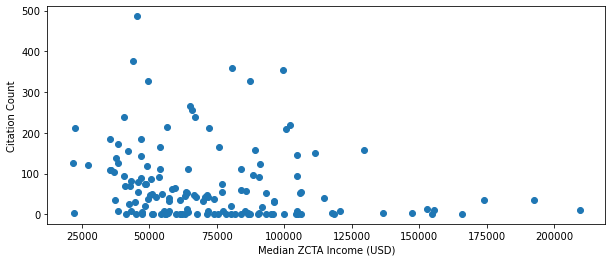

In [11]:
# filter out null median income data and low population
gpd_join_dem_income = gpd_join_dem[gpd_join_dem['median_income'] > 0].reset_index()
gpd_join_dem_income = gpd_join_dem_income[gpd_join_dem_income['population'] > 500].reset_index()

# plot
fig, ax = plt.subplots(figsize=(10,4))
ax.scatter(gpd_join_dem_income['median_income'], gpd_join_dem_income['count'])
ax.set_xlabel("Median ZCTA Income (USD)")
ax.set_ylabel("Citation Count")
plt.show()

It can be difficult to interpret the individual data points. Let's bucket them instead.

In [12]:
# groupby median_income_quantile
income_quantile_bar_data = gpd_join_dem_income.groupby('median_income_quantile').agg({'count':['sum'], 'population':['sum']}).reset_index()
income_quantile_bar_data.columns = ['median_income_quantile', 'count', 'population']
income_quantile_bar_data['count_per_thousand'] = income_quantile_bar_data['count'] / (income_quantile_bar_data['population']/1000)
income_quantile_bar_data

,median_income_quantile,count,population,count_per_thousand
0,0-20%,3083,1175144.0,2.623508
1,20-40%,2124,1521592.0,1.395906
2,40-60%,1739,1264887.0,1.374826
3,60-80%,1845,956994.0,1.927912
4,80-100%,1683,772501.0,2.178638


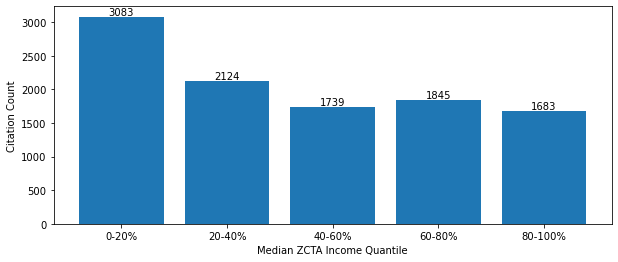

In [13]:
# plot
fig, ax = plt.subplots(figsize=(10,4))
ax.bar(income_quantile_bar_data['median_income_quantile'], income_quantile_bar_data['count'])
ax.set_xlabel("Median ZCTA Income Quantile")
ax.set_ylabel("Citation Count")
for i, v in enumerate(income_quantile_bar_data['count']):
    ax.text(i, v+25, str(v), color='black', horizontalalignment='center')
plt.show();

In [14]:
# print summary statement
bottom_quantile = income_quantile_bar_data.iloc[0]['median_income_quantile']
bottom_quantile_percent = '{0:.2f}'.format(income_quantile_bar_data.iloc[0]['count']/sum(income_quantile_bar_data['count'])*100)+'%'
print('ZCTAs in the bottom {0} for median income make up approximately {1} of the parking citations'.format(bottom_quantile, bottom_quantile_percent))

ZCTAs in the bottom 0-20% for median income make up approximately 29.43% of the parking citations


## Are there more parking citations in low-income areas, if we account for ZCTA population (proxy for size)?

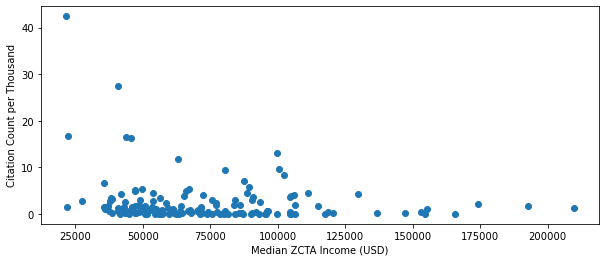

In [15]:
fig, ax = plt.subplots(figsize=(10,4))
ax.scatter(gpd_join_dem_income['median_income'], gpd_join_dem_income['count_per_thousand'])
ax.set_xlabel("Median ZCTA Income (USD)")
ax.set_ylabel("Citation Count per Thousand")
plt.show()

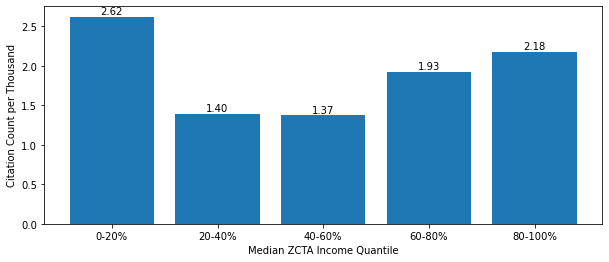

In [16]:
fig, ax = plt.subplots(figsize=(10,4))
ax.bar(income_quantile_bar_data['median_income_quantile'], income_quantile_bar_data['count_per_thousand'])
ax.set_xlabel("Median ZCTA Income Quantile")
ax.set_ylabel("Citation Count per Thousand")
for i, v in enumerate(income_quantile_bar_data['count_per_thousand']):
    ax.text(i, v+.03, "{:.2f}".format(v), color='black', horizontalalignment='center')
plt.show();

## Are there more parking citations in areas with greater non-white populations?

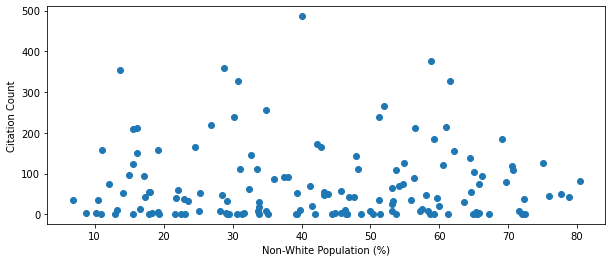

In [17]:
# filter out race
gpd_join_dem_race = gpd_join_dem[gpd_join_dem['population'] > 500].reset_index()

fig, ax = plt.subplots(figsize=(10,4))
ax.scatter(gpd_join_dem_race['nonwhite_percent'], gpd_join_dem_race['count'])
ax.set_xlabel("Non-White Population (%)")
ax.set_ylabel("Citation Count")
plt.show()

In [18]:
nonwhite_quantile_bar_data = gpd_join_dem_race.groupby('nonwhite_percent_quantile').agg({'count':['sum'], 'population':['sum']}).reset_index()
nonwhite_quantile_bar_data.columns = ['nonwhite_percent_quantile', 'count', 'population']
nonwhite_quantile_bar_data['count_per_thousand'] = nonwhite_quantile_bar_data['count'] / (nonwhite_quantile_bar_data['population']/1000)
nonwhite_quantile_bar_data

,nonwhite_percent_quantile,count,population,count_per_thousand
0,0-20%,2056,770075.0,2.669870
1,20-40%,2301,1061442.0,2.167806
2,40-60%,1827,1264839.0,1.444453
3,60-80%,2427,1310465.0,1.852014
4,80-100%,1879,1292293.0,1.454005


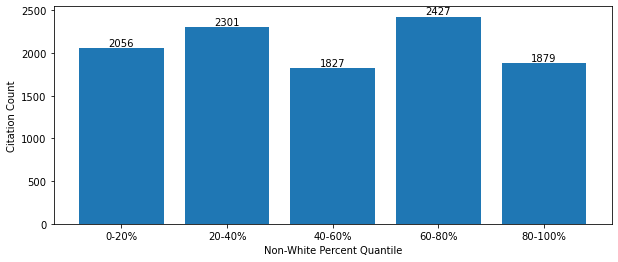

In [19]:
fig, ax = plt.subplots(figsize=(10,4))
ax.bar(nonwhite_quantile_bar_data['nonwhite_percent_quantile'], nonwhite_quantile_bar_data['count'])
ax.set_xlabel("Non-White Percent Quantile")
ax.set_ylabel("Citation Count")
for i, v in enumerate(nonwhite_quantile_bar_data['count']):
    ax.text(i, v+25, str(v), color='black', horizontalalignment='center')
plt.show();

## Are there more parking citations in areas with greater non-white populations, if we account for ZCTA population (proxy for size)?

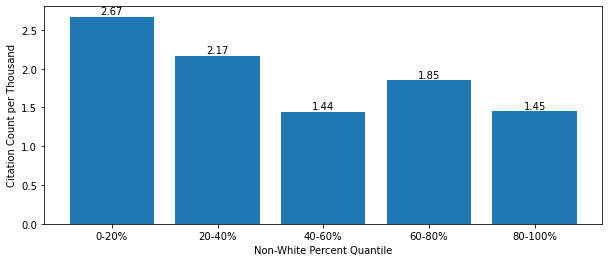

In [20]:
fig, ax = plt.subplots(figsize=(10,4))
ax.bar(nonwhite_quantile_bar_data['nonwhite_percent_quantile'], nonwhite_quantile_bar_data['count_per_thousand'])
ax.set_xlabel("Non-White Percent Quantile")
ax.set_ylabel("Citation Count per Thousand")
for i, v in enumerate(nonwhite_quantile_bar_data['count_per_thousand']):
    ax.text(i, v+.03, "{:.2f}".format(v), color='black', horizontalalignment='center')
plt.show();

## Are there more parking citations in areas with greater Hispanic populations?

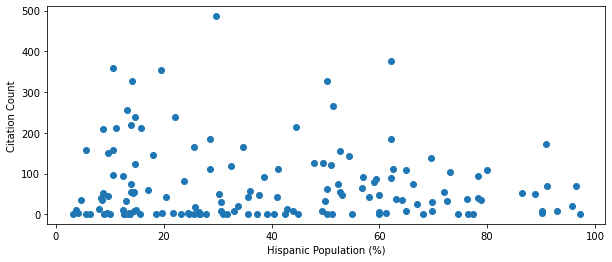

In [21]:
fig, ax = plt.subplots(figsize=(10,4))
ax.scatter(gpd_join_dem_race['hispanic_percent'], gpd_join_dem_race['count'])
ax.set_xlabel("Hispanic Population (%)")
ax.set_ylabel("Citation Count")
plt.show()

In [22]:
hispanic_quantile_bar_data = gpd_join_dem_race.groupby('hispanic_percent_quantile').agg({'count':['sum'], 'population':['sum']}).reset_index()
hispanic_quantile_bar_data.columns = ['hispanic_percent_quantile', 'count', 'population']
hispanic_quantile_bar_data['count_per_thousand'] = hispanic_quantile_bar_data['count'] / (hispanic_quantile_bar_data['population']/1000)
hispanic_quantile_bar_data

,hispanic_percent_quantile,count,population,count_per_thousand
0,0-20%,1985,689513.0,2.878843
1,20-40%,2515,834799.0,3.012701
2,40-60%,1825,981681.0,1.859056
3,60-80%,2768,1470017.0,1.882971
4,80-100%,1397,1723104.0,0.810746


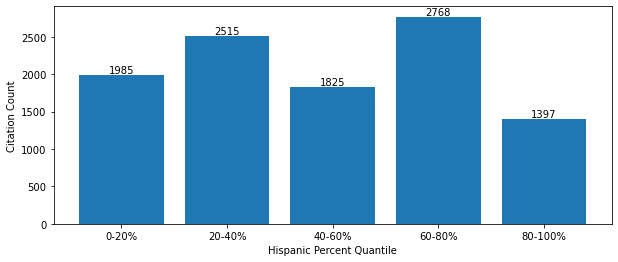

In [23]:
fig, ax = plt.subplots(figsize=(10,4))
ax.bar(hispanic_quantile_bar_data['hispanic_percent_quantile'], hispanic_quantile_bar_data['count'])
ax.set_xlabel("Hispanic Percent Quantile")
ax.set_ylabel("Citation Count")
for i, v in enumerate(hispanic_quantile_bar_data['count']):
    ax.text(i, v+25, str(v), color='black', horizontalalignment='center')
plt.show();

## Are there more parking citations in areas with greater Hispanic populations, if we account for ZCTA population (proxy for size)?

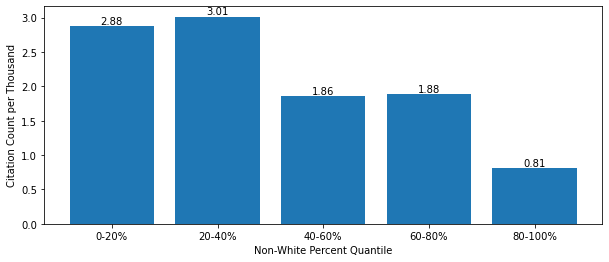

In [24]:
fig, ax = plt.subplots(figsize=(10,4))
ax.bar(hispanic_quantile_bar_data['hispanic_percent_quantile'], hispanic_quantile_bar_data['count_per_thousand'])
ax.set_xlabel("Non-White Percent Quantile")
ax.set_ylabel("Citation Count per Thousand")
for i, v in enumerate(hispanic_quantile_bar_data['count_per_thousand']):
    ax.text(i, v+.03, "{:.2f}".format(v), color='black', horizontalalignment='center')
plt.show();

## Are there more parking citations in areas with greater diversity?

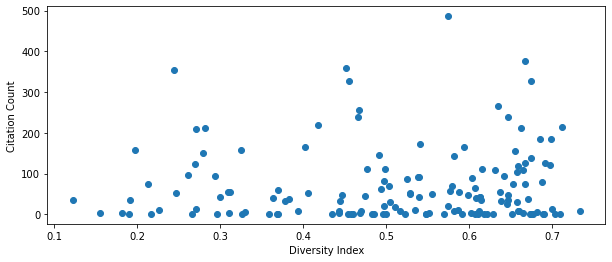

In [25]:
fig, ax = plt.subplots(figsize=(10,4))
ax.scatter(gpd_join_dem_race['diversity_index'], gpd_join_dem_race['count'])
ax.set_xlabel("Diversity Index")
ax.set_ylabel("Citation Count")
plt.show()

In [26]:
diversity_quantile_bar_data = gpd_join_dem_race.groupby('diversity_index_quantile').agg({'count':['sum'], 'population':['sum']}).reset_index()
diversity_quantile_bar_data.columns = ['diversity_index_quantile', 'count', 'population']
diversity_quantile_bar_data['count_per_thousand'] = diversity_quantile_bar_data['count'] / (diversity_quantile_bar_data['population']/1000)
diversity_quantile_bar_data

,diversity_index_quantile,count,population,count_per_thousand
0,0-20%,1996,719501.0,2.774145
1,20-40%,2238,962319.0,2.325632
2,40-60%,1846,1380813.0,1.336894
3,60-80%,1794,1286169.0,1.394840
4,80-100%,2616,1350312.0,1.937330


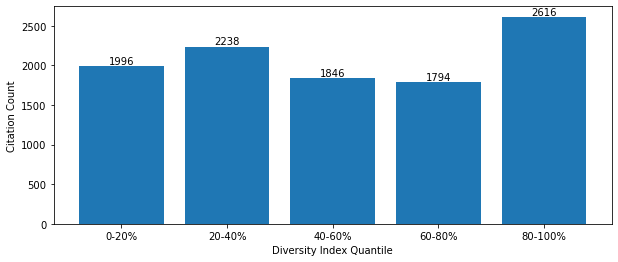

In [27]:
fig, ax = plt.subplots(figsize=(10,4))
ax.bar(diversity_quantile_bar_data['diversity_index_quantile'], diversity_quantile_bar_data['count'])
ax.set_xlabel("Diversity Index Quantile")
ax.set_ylabel("Citation Count")
for i, v in enumerate(diversity_quantile_bar_data['count']):
    ax.text(i, v+25, str(v), color='black', horizontalalignment='center')
plt.show();

## Are there more parking citations in areas with greater diversity, if we account for ZCTA population (proxy for size)?

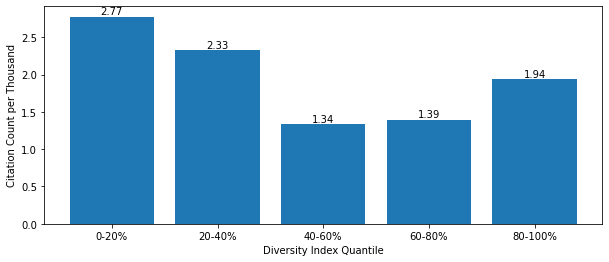

In [28]:
fig, ax = plt.subplots(figsize=(10,4))
ax.bar(diversity_quantile_bar_data['diversity_index_quantile'], diversity_quantile_bar_data['count_per_thousand'])
ax.set_xlabel("Diversity Index Quantile")
ax.set_ylabel("Citation Count per Thousand")
for i, v in enumerate(diversity_quantile_bar_data['count_per_thousand']):
    ax.text(i, v+.03, "{:.2f}".format(v), color='black', horizontalalignment='center')
plt.show();

## Do areas with lower income populations get more street cleaning tickets?

In [29]:
gpd_join.head()

,state_plate,make,body_style,color,location,violation_code,violation_description,fine_amount,datetime,latitude,...,index_right,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10
index,,,,,,,,,,,,,,,,,,,,,
0,CA,Kia,PA,WT,600 LARCHMONT BL N,88.13B+,METER EXP.,63,2015-12-30 11:19:00,34.081677,...,584,90004,90004,B5,G6350,S,7894528,0,+34.0761981,-118.3107225
1,CA,Toyota,PA,GO,132 CLARK DR S,80.58L,PREFERENTIAL PARKING,68,2015-12-30 18:50:00,34.075151,...,626,90048,90048,B5,G6350,S,4884083,0,+34.0729253,-118.3727108
2,CT,Chevrolet,PA,BN,830 SOUTH NORTON AVENUE,80.69BS,NO PARK/STREET CLEAN,73,2015-12-30 11:04:00,34.057482,...,585,90005,90005,B5,G6350,S,2807558,0,+34.0591634,-118.3068924
3,CA,Hyundai,PA,WT,1701 LAS PALMAS AV N,88.13B+,METER EXP.,63,2015-12-30 11:15:00,34.101561,...,607,90028,90028,B5,G6350,S,3947879,0,+34.0999122,-118.3269118
4,CA,Honda,PA,BK,1631 219TH ST,5204A-,DISPLAY OF TABS,25,2015-12-30 08:14:00,33.829107,...,709,90501,90501,B5,G6350,S,14659585,8095,+33.8337437,-118.3140219


In [30]:
# filter for street cleaning citations
gpd_join_streetclean = gpd_join[gpd_join['violation_description'] == 'NO PARK/STREET CLEAN']
gpd_join_streetclean = pd.DataFrame(gpd_join_streetclean.groupby('ZCTA5CE10').size(), columns=['count']).reset_index()
gpd_join_streetclean = gpd_join_streetclean.merge(gpd_join_dem[['ZCTA5CE10', 'median_income', 'median_income_quantile', 'population']], on='ZCTA5CE10', how='left')
gpd_join_streetclean.head()

,ZCTA5CE10,count,median_income,median_income_quantile,population
0,90001,1,43360.0,0-20%,59832.0
1,90002,15,37285.0,0-20%,53302.0
2,90003,32,40598.0,0-20%,73730.0
3,90004,96,49675.0,20-40%,60541.0
4,90005,30,38491.0,0-20%,39732.0


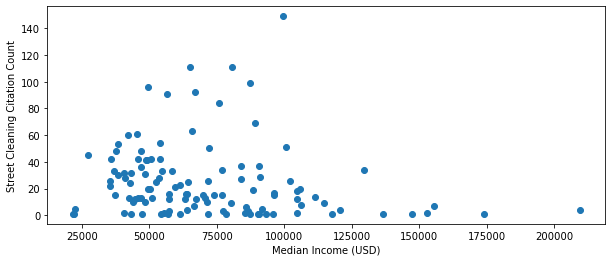

In [31]:
# filter for median_income > 0
gpd_join_streetclean_income = gpd_join_streetclean[gpd_join_streetclean['median_income'] > 0]

fig, ax = plt.subplots(figsize=(10,4))
ax.scatter(gpd_join_streetclean_income['median_income'], gpd_join_streetclean_income['count'])
ax.set_xlabel("Median Income (USD)")
ax.set_ylabel("Street Cleaning Citation Count")
plt.show()

In [32]:
# groupby median_income_quantile
streetclean_income_quantile_bar_data = gpd_join_streetclean_income.groupby('median_income_quantile').agg({'count':['sum'], 'population':['sum']}).reset_index()
streetclean_income_quantile_bar_data.columns = ['median_income_quantile', 'count', 'population']
streetclean_income_quantile_bar_data['count_per_thousand'] = income_quantile_bar_data['count'] / (streetclean_income_quantile_bar_data['population']/1000)
streetclean_income_quantile_bar_data

,median_income_quantile,count,population,count_per_thousand
0,0-20%,596,1002378.0,3.075686
1,20-40%,756,1175873.0,1.806318
2,40-60%,570,1031330.0,1.686172
3,60-80%,609,777241.0,2.373781
4,80-100%,397,594716.0,2.829922


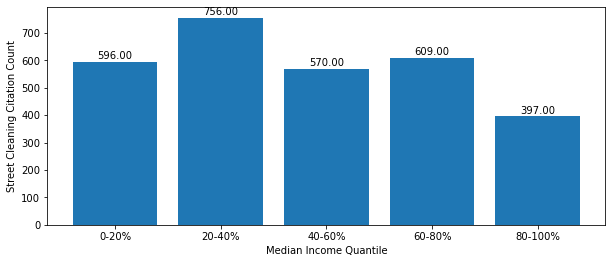

In [33]:
fig, ax = plt.subplots(figsize=(10,4))
ax.bar(streetclean_income_quantile_bar_data['median_income_quantile'], streetclean_income_quantile_bar_data['count'])
ax.set_xlabel("Median Income Quantile")
ax.set_ylabel("Street Cleaning Citation Count")
for i, v in enumerate(streetclean_income_quantile_bar_data['count']):
    ax.text(i, v+10, "{:.2f}".format(v), color='black', horizontalalignment='center')
plt.show();

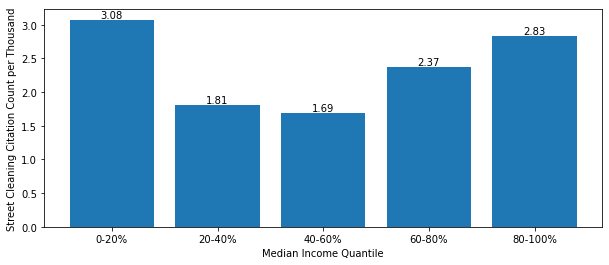

In [34]:
fig, ax = plt.subplots(figsize=(10,4))
ax.bar(streetclean_income_quantile_bar_data['median_income_quantile'], streetclean_income_quantile_bar_data['count_per_thousand'])
ax.set_xlabel("Median Income Quantile")
ax.set_ylabel("Street Cleaning Citation Count per Thousand")
for i, v in enumerate(streetclean_income_quantile_bar_data['count_per_thousand']):
    ax.text(i, v+.03, "{:.2f}".format(v), color='black', horizontalalignment='center')
plt.show();